# House Prices - Advanced Regression Techniques
## [書面報告](https://drive.google.com/file/d/1bjunedOkFKUyuTTusPhqGk7hfpWWn6Ts/view?usp=sharing)

## [Kaggle連結網址](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
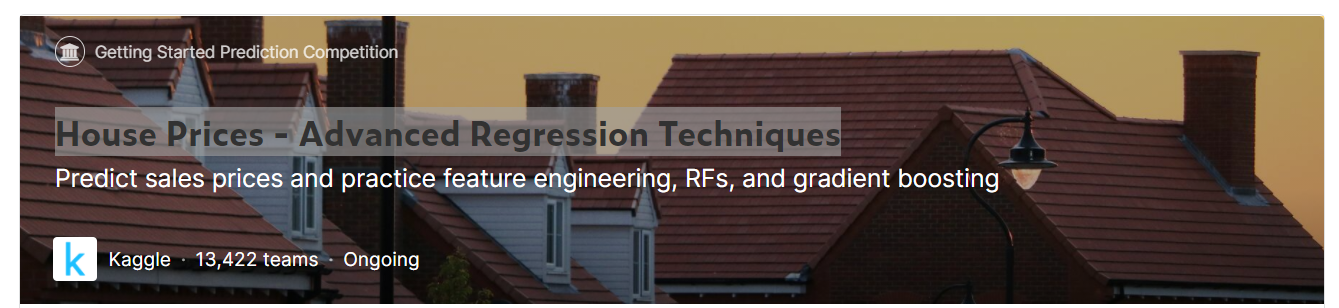

# STEP 1.1資料讀取

In [2]:
# 請勿更動此區塊程式碼

import time

EXECUTION_START_TIME = time.time() # 計算執行時間

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

%pylab inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Populating the interactive namespace from numpy and matplotlib


C:\Users\David\anaconda3\envs\tf_2.0\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
train = pd.read_csv('C:/train.csv')
test = pd.read_csv('C:/test.csv')
print("訓練資料大小：",train.shape)
print("測試資料大小：",test.shape)

訓練資料大小： (1460, 81)
測試資料大小： (1459, 80)


# Step 1.2 連續型類別型數量統計

In [5]:
#用不到ID 先將其保存後從資料及刪除
train_id=train['Id']
test_id=test['Id']
train=train.drop(columns='Id')
test=test.drop(columns='Id')
#合併訓練和測試資料，以方便做資料處理
combine= pd.concat([train, test], axis=0, ignore_index=True)
#取出SalePrice(即我們要預測的column，並從combine中刪除)
saleprice=train['SalePrice']
combine=combine.drop(columns='SalePrice')


<AxesSubplot:>

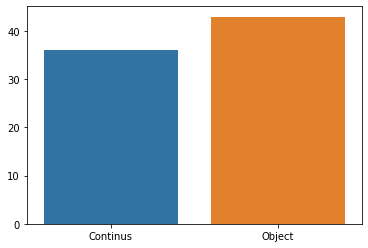

In [6]:
Object=0
Continus=0
for i in combine:
  if(np.dtype(combine[i])=='object'):
    Object+=1
  else:
    Continus+=1
ll = {'x':['Continus','Object'],
      'y':[Continus,Object]
     }
sns.barplot(x='x',y='y',data=ll)

# Step1.4 用seaborn表示缺失值

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 [Text(0, 0, 'PoolQC'),
  Text(1, 0, 'MiscFeature'),
  Text(2, 0, 'Alley'),
  Text(3, 0, 'Fence'),
  Text(4, 0, 'FireplaceQu'),
  Text(5, 0, 'LotFrontage'),
  Text(6, 0, 'GarageFinish'),
  Text(7, 0, 'GarageYrBlt'),
  Text(8, 0, 'GarageQual'),
  Text(9, 0, 'GarageCond'),
  Text(10, 0, 'GarageType'),
  Text(11, 0, 'BsmtExposure'),
  Text(12, 0, 'BsmtCond'),
  Text(13, 0, 'BsmtQual'),
  Text(14, 0, 'BsmtFinType2'),
  Text(15, 0, 'BsmtFinType1'),
  Text(16, 0, 'MasVnrType'),
  Text(17, 0, 'MasVnrArea'),
  Text(18, 0, 'MSZoning'),
  Text(19, 0, 'BsmtFullBath'),
  Text(20, 0, 'BsmtHalfBath'),
  Text(21, 0, 'Utilities'),
  Text(22, 0, 'Functional'),
  Text(23, 0, 'Exterior2nd'),
  Text(24, 0, 'Exterior1st'),
  Text(25, 0, 'SaleType'),
  Text(26, 0, 'BsmtFinSF1'),
  Text(27, 0, 'BsmtFinSF2'),
  Text(28, 0, 'BsmtUnfSF'),
  Text(29, 0, 'Electr

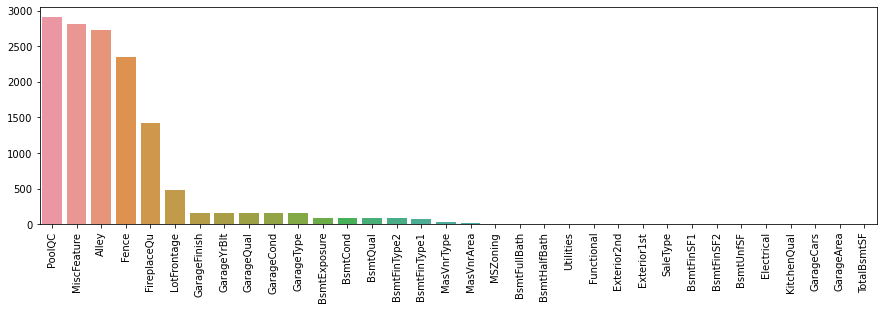

In [7]:
#check train null data
col_null_info = combine.isnull().sum(); 
col_null_info = col_null_info[col_null_info>0].sort_values(ascending=False)
plt.figure(figsize=(15,4))
g=sns.barplot(x=col_null_info.index, y=col_null_info.values)
plt.xticks(rotation=90)
#g.set_xticklabels(rotation=90)

# Step 1.5 用Heatmap找與SalePrice相關係數

<AxesSubplot:>

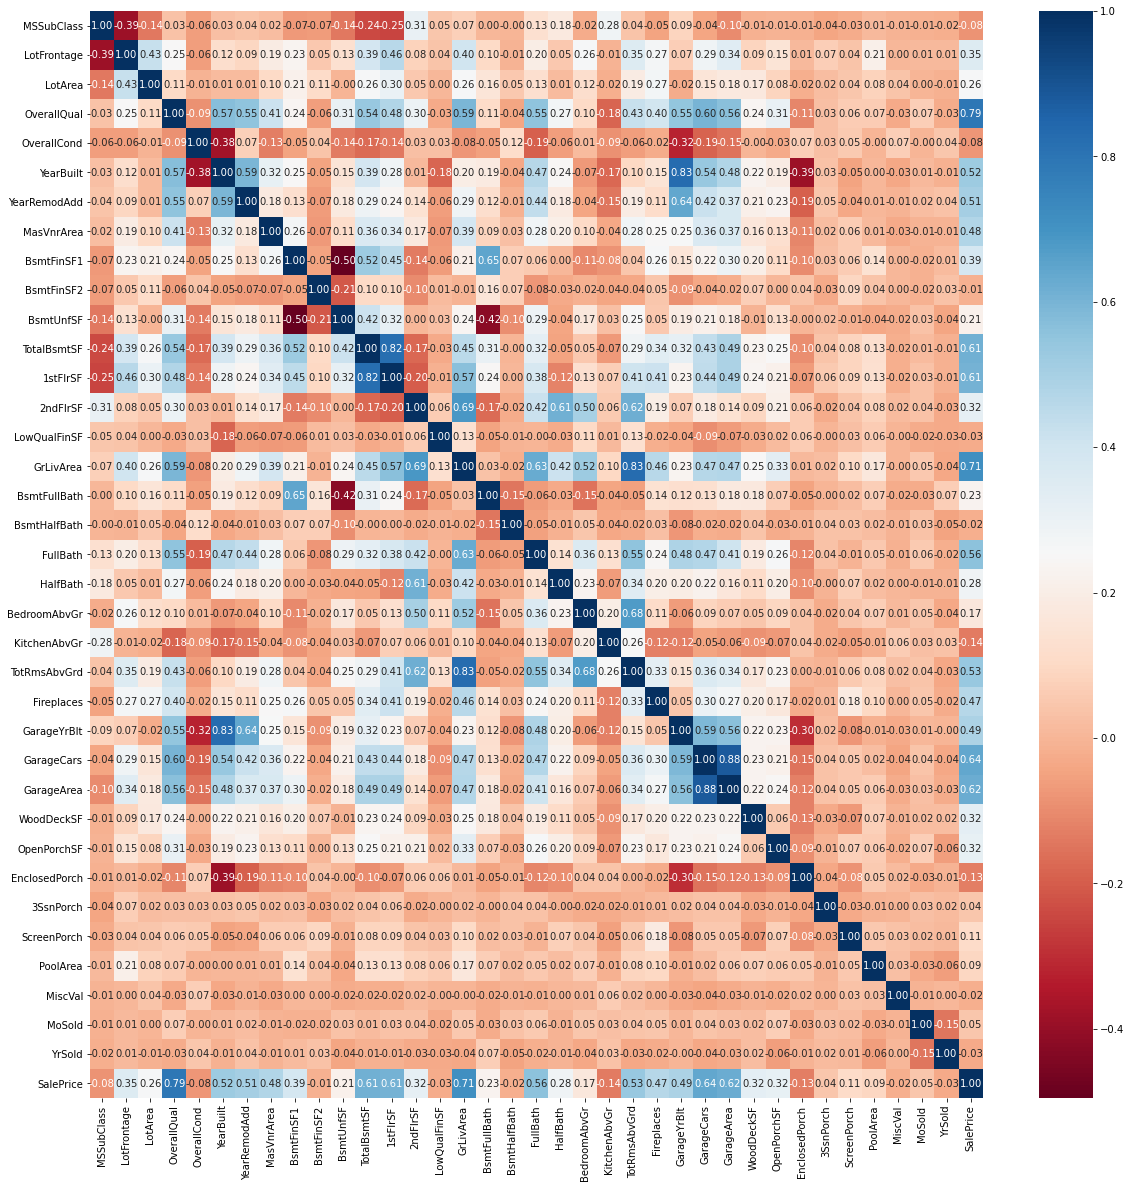

In [8]:
plt.figure(figsize=(20, 20))
train_corr = train.corr()
sns.heatmap(train_corr, annot=True, fmt = ".2f" ,cmap='RdBu')

In [9]:
TEMP=train_corr['SalePrice']
TEMP=TEMP.sort_values(ascending=False)
TEMP=TEMP.drop('SalePrice')
df = pd.DataFrame(TEMP)



*   大部分特徵都和SalePrice正相關


*   OverallQual,GrLivArea和SalePrice相關度極高





# Step 2.1 **缺失值處理**

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

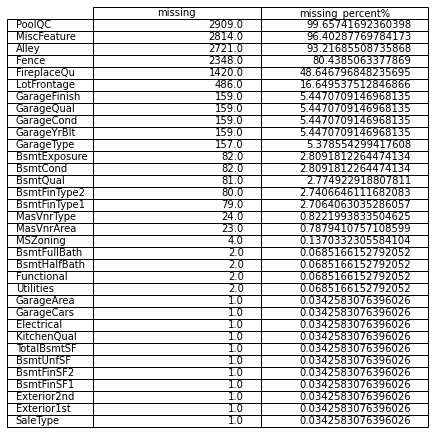

In [11]:
#查看缺失值
missing=combine.isnull().sum()
missing_percent=100*(missing/combine.shape[0])
missing_df=pd.DataFrame({'missing':missing,'missing_percent%':missing_percent})
missing_df=missing_df[missing_df['missing']!=0].sort_values('missing',ascending=False)
missing_df
ax = plt.axes(frame_on=False)# 不要額外框線
ax.xaxis.set_visible(False)  # 隱藏X軸刻度線
ax.yaxis.set_visible(False)  # 隱藏Y軸刻度線

pd.plotting.table(ax,data=missing_df, loc='center') #將mytable投射到ax上，且放置於ax的中間



*   PoolQC, MiscFeature, Alley, Fence, FireplaceQu, LotFrontage這些的是缺失值較多的特徵
*   Garage：和車庫有關的特徵有一樣的缺失值
*   Bsmt:和地下室有關的特徵有一樣的缺失值





In [12]:
#處理缺失值
#用眾數去處理填缺失值
combine['Functional']=combine['Functional'].fillna(combine['Functional'].mode()[0])
combine['Electrical']=combine['Electrical'].fillna(combine['Electrical'].mode()[0])
combine['KitchenQual'] = combine['KitchenQual'].fillna(combine['KitchenQual'].mode()[0])
combine['Exterior1st'] = combine['Exterior1st'].fillna(combine['Exterior1st'].mode()[0])
combine['Exterior2nd'] = combine['Exterior2nd'].fillna(combine['Exterior2nd'].mode()[0])
combine['SaleType'] = combine['SaleType'].fillna(combine['SaleType'].mode()[0])
#MSZoning和MSSubClass有關，用分组後的數填缺失值
combine['MSZoning'] = combine.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
# LotFrontage和Neighborhood相關，用分组后的中位数替代
combine['LotFrontage'] =combine.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
#用0取代Garage的數值型特徵
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars'] :
   combine[col] = combine[col].fillna(0)
#用None取代Garage的文字型特徵
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
  combine[col]=combine[col].fillna('None')
#用None替代地下室的文字型特徵 
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    combine[col] = combine[col].fillna('None')  

#剩下的數值型特徵無意義，用0取代
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in combine.columns:
  if combine[i].dtype in numeric_dtypes:
    numeric.append(i)
combine.update(combine[numeric].fillna(0))   
#剩下的文字型特徵無無意義，用None取代
objects=[]
for i in combine.columns:
  if combine[i].dtype== object:
    objects.append(i)
combine.update(combine[objects].fillna('None'))
#刪除缺失值80%以上的特徵
combine.drop(columns=['PoolQC','MiscFeature','Alley','Fence'],inplace=True)


# Step 2.2 離群值刪除

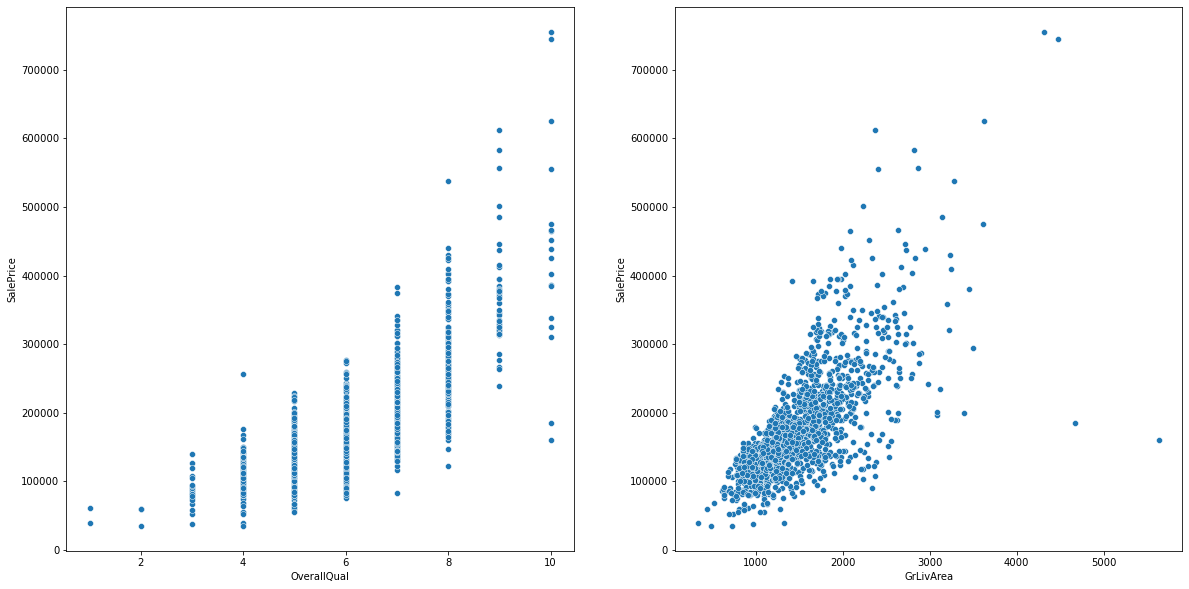

In [13]:
#選用上面兩個相關度極高的特徵來繪製分佈圖，以尋找離群值
cols=['OverallQual','GrLivArea']
fig,ax=plt.subplots(1,2,figsize=(20,10))

index=0
for col in cols:
  sns.scatterplot(x=train[col],y=saleprice,ax=ax[index])
  index+=1
 


In [14]:
#刪除離群值
outlier1 = []
for i in range(3,11):
    temp = train[train['OverallQual']==i]
    q1, q3 = np.quantile(temp['SalePrice'], [0.25, 0.75])
    low = q1 - 1.5 * (q3 - q1) 
    high = q3 + 1.5 * (q3 - q1)
    outlier1+=(train[(train['OverallQual']==i) & ((train['SalePrice']>high)|(train['SalePrice']<low))].index.tolist())
outlier2 = train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index.tolist()
outliers = list(set(outlier1+outlier2))
# 特徵矩陣以及saleprice都需要删除
combine.drop(index=outliers, inplace=True)
saleprice.drop(index=outliers, inplace=True)


In [15]:
# 重置索引
combine.reset_index(drop=True, inplace=True)
saleprice.reset_index(drop=True, inplace=True)

In [16]:
temp = train.copy()

In [17]:
temp.shape
saleprice.shape

(1405,)

In [18]:

temp.drop(index=outliers, inplace=True)
temp.reset_index(drop=True, inplace=True)


## Step2.3 刪除後的離群值
* **紅色代表原始數據**
* **藍色代表刪除後數據**

<function matplotlib.pyplot.show(close=None, block=None)>

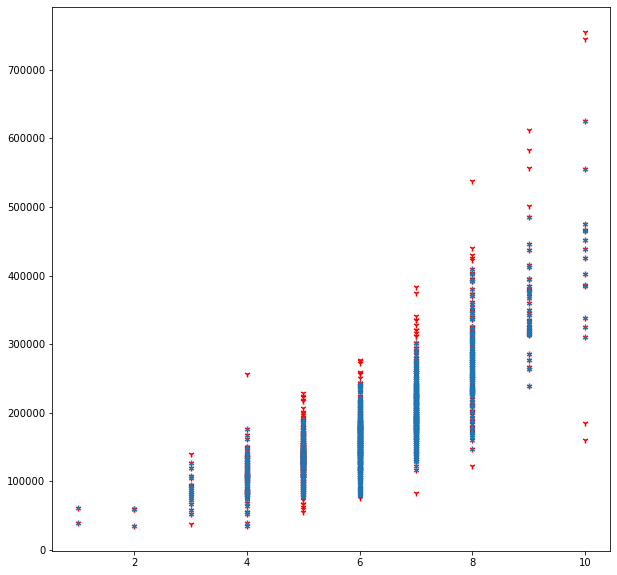

In [19]:
plt.figure(figsize=(10, 10))

plt.scatter(
    x=train['OverallQual'],
    y=train['SalePrice'],
    marker='1',
    color='red'
)
plt.scatter(
    x=temp['OverallQual'],
    y=saleprice,
    marker='2'
)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

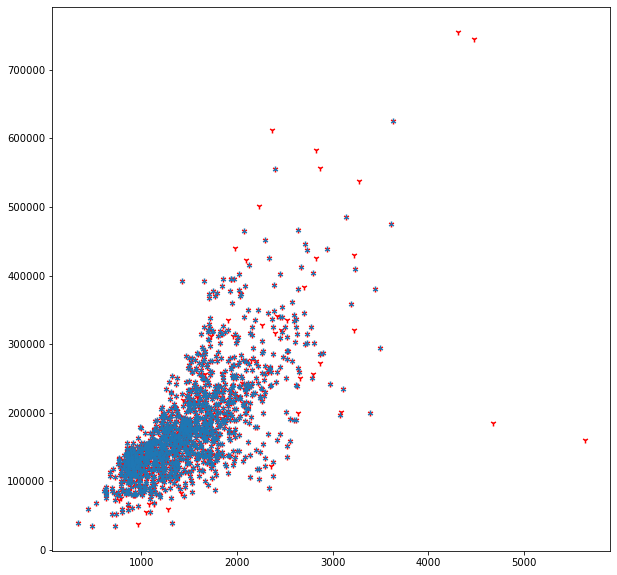

In [20]:
plt.figure(figsize=(10, 10))

plt.scatter(
    x=train['GrLivArea'],
    y=train['SalePrice'],
    marker='1',
    color='red'
)
plt.scatter(
    x=temp['GrLivArea'],
    y=saleprice,
    marker='2'
)
plt.show

# Step2.4區分數字型和文字型特徵

In [21]:
#找到數字型特徵
num_col=combine._get_numeric_data().columns.tolist()
#找到文字型特徵
catogo_col=set(combine.columns)-set(num_col)

#算每一個文字型特徵的total value
for i in catogo_col:
  print(combine[i].value_counts())

WD       2484
New       227
COD        86
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64
Unf     2446
Rec      103
LwQ       85
None      79
BLQ       65
ALQ       52
GLQ       34
Name: BsmtFinType2, dtype: int64
SBrkr    2623
FuseA     184
FuseF      50
FuseP       7
Name: Electrical, dtype: int64
CompShg    2825
Tar&Grv      21
WdShake       9
WdShngl       6
Membran       1
Roll          1
Metal         1
Name: RoofMatl, dtype: int64
TA      1265
Gd      1190
Ex       244
Fa        85
None      80
Name: BsmtQual, dtype: int64
TA    2495
Gd     289
Fa      65
Ex      12
Po       3
Name: ExterCond, dtype: int64
Y    2590
N     212
P      62
Name: PavedDrive, dtype: int64
TA    1476
Gd    1129
Ex     190
Fa      69
Name: KitchenQual, dtype: int64
Norm      2835
Feedr       13
Artery       5
PosA         4
PosN         3
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64
1Story    1451
2Story     

## Step 2.5 SalePrice分佈
* **確定是不是normal distribution**
* **可發現SalePrice非normal distribution，後面需要處理**

C:\Users\David\anaconda3\envs\tf_2.0\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(array([-200000.,       0.,  200000.,  400000.,  600000.,  800000.,
        1000000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

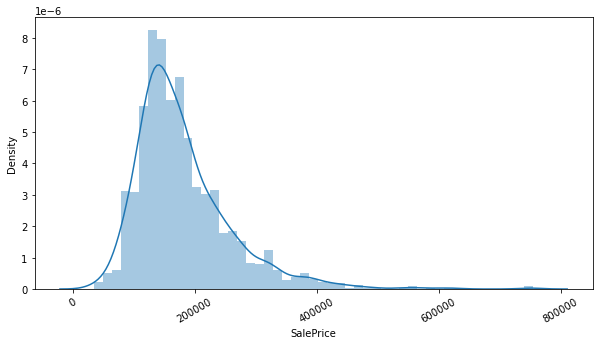

In [22]:
plt.figure(figsize=(10,5))
sns.distplot(train['SalePrice'])
plt.xticks(rotation=30)

## Step2.6 找與SalePrice相關係數>0.5來畫Heatmap



*   OverallQual,GrLivArea,GarageCars和SalePrice的相關度極高
*   部分特徵間也存在很高相關度：
    - GarageCars & GarageArea
    - TotRmsAbvGrd和GrLivArea
* 由此可知此資料集可能為多變量線性回歸，應盡量避免使用線性回歸模型




<AxesSubplot:>

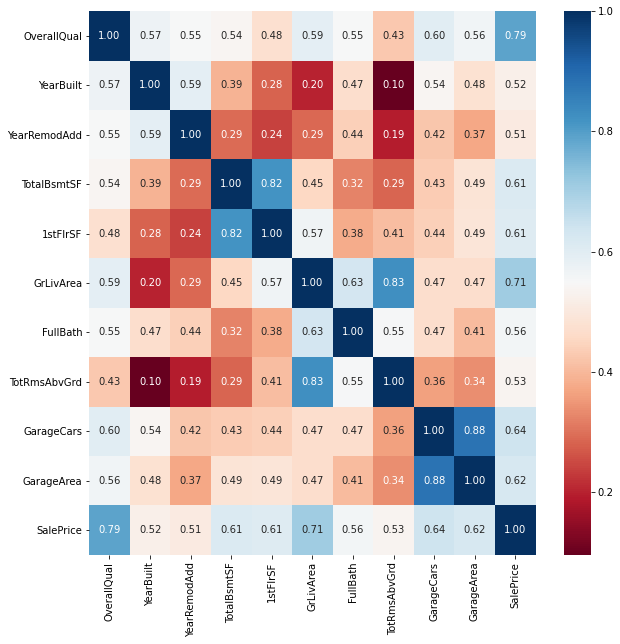

In [23]:
#因特徵太多，取和saleprice相關的絕對值>0.5的來畫圖
plt.figure(figsize=(10,10))
corrnum=train.corr()
top_cols = corrnum.index[abs(corrnum["SalePrice"])>0.5]
train_corr_top=train.loc[:,top_cols].corr()
sns.heatmap(train_corr_top,annot=True, fmt = ".2f",cmap='RdBu')

## Step2.7**特徵工程**
 * **創造新特徵**
    * 把一些有強烈關係的特徵組合

In [24]:
#創造新特徵
combine['TotalSF'] = combine['TotalBsmtSF'] + combine['1stFlrSF'] + combine['2ndFlrSF']
combine['YrSinceRemod'] = combine['YrSold'].astype(int) - combine['YearRemodAdd'].astype(int)
combine['YrSinceBuilt'] = combine['YrSold'].astype(int) - combine['YearBuilt'].astype(int)
combine['OverallEval'] = combine['OverallQual'] + combine['OverallCond']
combine['LowQualPct'] = combine['LowQualFinSF'] / combine['TotalSF']
combine['funcSF'] = combine['WoodDeckSF'] + combine['OpenPorchSF'] + combine['EnclosedPorch'] + combine['3SsnPorch'] +combine['ScreenPorch'] + combine['PoolArea']


## Step 2.8**有順序的特徵編碼**
* 有些文字型特徵的值是有順序的，無法用one-hot encoding

In [25]:
order_map={'Ex':0,'Gd':1,'TA':2,'Fa':3,'Po':4,'None':5}
order_cols=['BsmtCond','BsmtQual','ExterCond','ExterQual','FireplaceQu',
            'GarageCond','GarageQual','HeatingQC','KitchenQual']
for col in order_cols:
  combine[col]=combine[col].map(order_map).astype(int)

 ## Step 2.9**修正資料類型**
 * 將一些數字型特徵修改成文字型（避免後續拿來做計算）

In [26]:

combine['MSSubClass'] = combine['MSSubClass'].astype(object)
combine['YrSold'] = combine['YrSold'].astype(object)
combine['MoSold'] = combine['MoSold'].astype(object)



## Step2.10 **時間類型的特徵編碼**
* 將有順序性的時間進行編碼

In [27]:
from sklearn.preprocessing import LabelEncoder
time_cols = ['GarageYrBlt','YearBuilt','YearRemodAdd','YrSold']
for col in time_cols:
    combine[col] = LabelEncoder().fit_transform(combine[col])

## Step2.11 **數字型特徵的對數變換**
* 觀察數值型特徵的分佈，看其是否符合normal disribution

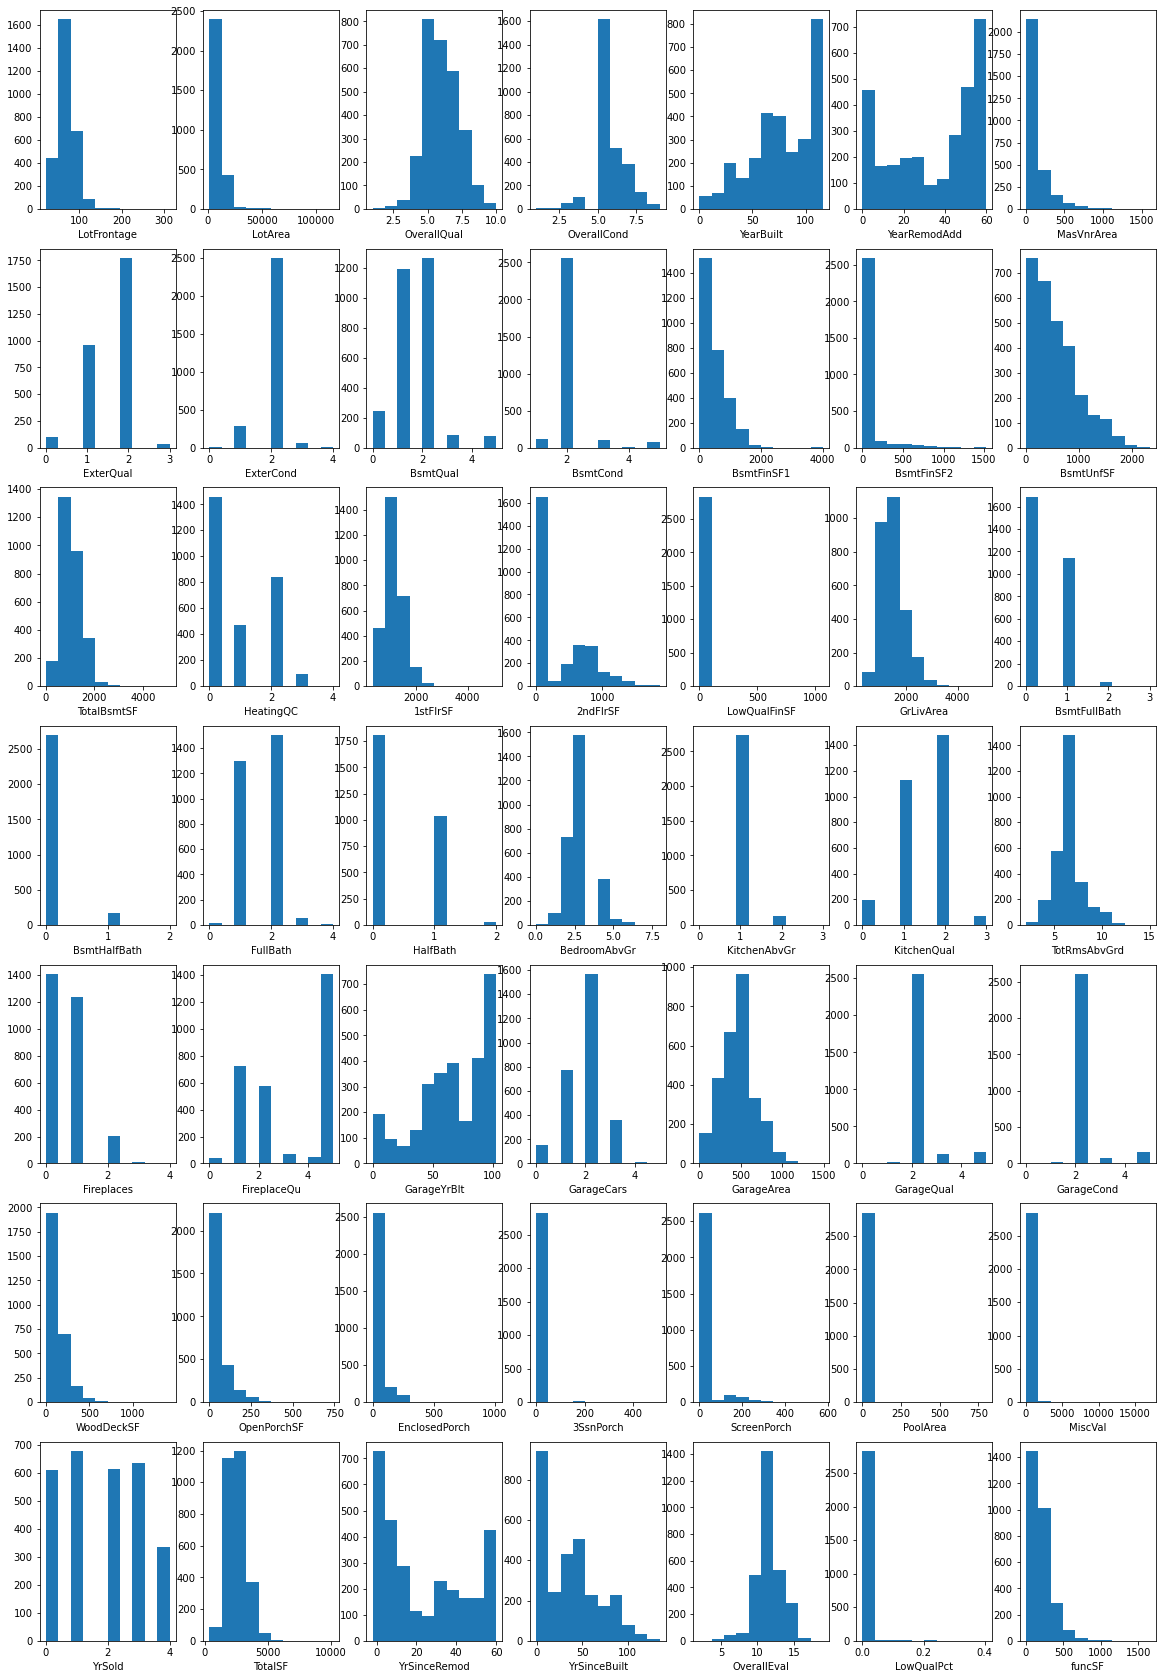

In [28]:
#找到數字型特徵
num_cols=combine._get_numeric_data().columns.tolist()

#畫圖去看特徵的值的分佈
fig = plt.figure(figsize=(20, 30))
for col in num_cols:
    ax = fig.add_subplot(7, 7, num_cols.index(col)+1)
    ax.set_xlabel(col)
    ax.hist(combine[col])


## Step 2.12 偏度計算
* [Transforming Skewed Data for Machine Learning](https://medium.com/@ODSC/transforming-skewed-data-for-machine-learning-90e6cc364b0)

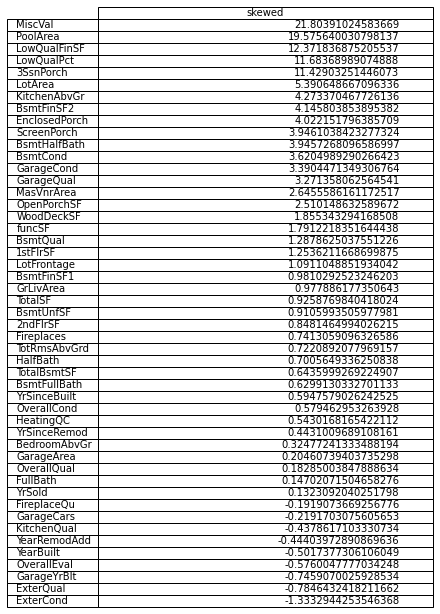

In [29]:
# 計算skewed的量
skewed_cols = combine[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
skewed_df = pd.DataFrame({'skewed':skewed_cols})
skewed_df
ax = plt.axes(frame_on=False)# 不要額外框線
ax.xaxis.set_visible(False)  # 隱藏X軸刻度線
ax.yaxis.set_visible(False)  # 隱藏Y軸刻度線

pd.plotting.table(ax,data=skewed_df, loc='center') #將mytable投射到ax上，且放置於ax的中間

C:\Users\David\anaconda3\envs\tf_2.0\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


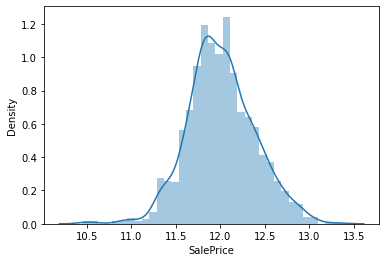

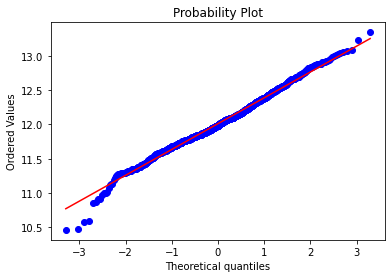

In [30]:
#skewed偏度的絕對值>1的特徵作對數變換
skewed_cols = skewed_df[skewed_df['skewed'].abs()>1].index.tolist()
for col in skewed_cols:
    combine[col] = np.log1p(combine[col])

#SalePrice也不是normal distribution，一樣進行對數變換
saleprice = np.log1p(saleprice)
sns.distplot(saleprice)
fig = plt.figure()
res = stats.probplot(saleprice, plot=plt)

## Step 2.13 **One-Hot  encoding**

In [31]:
#把剩下的文字性特徵編碼
combine= pd.get_dummies(combine)
combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Columns: 279 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(29), int32(7), int64(13), uint8(230)
memory usage: 1.6 MB


### 可以看到全部都轉成連續型

<AxesSubplot:>

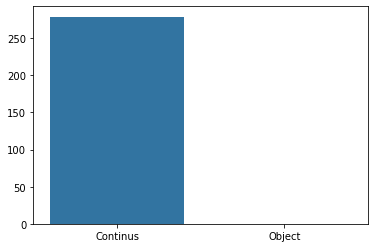

In [43]:
Object=0
Continus=0
for i in combine:
  if(np.dtype(combine[i])=='object'):
    Object+=1
  else:
    Continus+=1
ll = {'x':['Continus','Object'],
      'y':[Continus,Object]
     }
sns.barplot(x='x',y='y',data=ll)

## Step 2.14 **還原訓練和測試資料集**

In [32]:
train_clean=combine.iloc[:1405,:]
test_clean=combine.iloc[1405:,:]
train_clean=pd.concat([train_clean,saleprice],axis=1)
print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


##  Step 3.1 **模型建立**
* **導入套件**

In [33]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [34]:
#劃分資料集
X=train_clean.drop(columns='SalePrice')
Y=train_clean['SalePrice']

X_train, X_test, Y_train, Y_test =train_test_split(X,Y,train_size=0.7,random_state=10)
print(X_train.shape) 
print(X_test.shape) 
print(Y_train.shape) 
print(Y_test.shape) 

(983, 279)
(422, 279)
(983,)
(422,)


## Step3.2 K-Fold Validation

In [35]:
#交叉驗證
kf = KFold(n_splits=10, random_state=50, shuffle=True)
def rmse(y, y_pred):
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return rmse

def cv_rmse(model, X=X,Y=Y):
    rmse = np.sqrt(-cross_val_score(model, X, Y, scoring='neg_mean_squared_error', cv=kf))
    return rmse
#建立regression模型
lgb = LGBMRegressor(objective='regression', random_state=50)
xgb = XGBRegressor(objective='reg:linear', random_state=50, silent=True)
rf = RandomForestRegressor(random_state=50)

## Step3.3 **模型參數優化**
* 用GridSearch來將參數優化

In [36]:
#優化後的模型
best_lgb = LGBMRegressor(objeactive='regression'
                    ,n_estimators=1200
                    ,max_depth=8
                    ,num_leaves=10
                    ,min_data_in_leaf=3
                    ,max_bin=25
                    ,bagging_fraction=0.6
                    ,bagging_freq=11
                    ,feature_fraction=0.6
                    ,learning_rate=0.01
                    ,random_state=50
                    ,n_jobs=4)

best_xgb = XGBRegressor(objective='reg:linear'
                   ,n_estimators=2200
                   ,learning_rate=0.05
                   ,max_depth=3
                   ,subsample=0.6
                   ,min_child_weight=3
                   ,colsample_bytree=0.5
                   ,random_state=50
                   ,n_jobs=4
                   ,silent=True)

best_rf = RandomForestRegressor(n_estimators=70,
                           min_impurity_decrease=0.002,
                           min_weight_fraction_leaf=0.001,
                           min_samples_split=5,
                           random_state=50,
                           n_jobs=4)

## Step3.4 模型訓練

In [37]:
#模型優化後評估
best_models=[best_lgb,best_xgb,best_rf]
best_model_names=[best_lgb,best_xgb,best_rf]
scores = {}
for i, model in enumerate(best_models):
  score=cv_rmse(model)
  scores[best_model_names[i]] = (score.mean(), score.std())

scores_df=pd.DataFrame(scores,index=['rmse_score','rmse_std'])
scores_df.sort_values('rmse_score', axis=1, inplace=True)
scores_df

[LightGBM] [Warning] Unknown parameter: objeactive
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] Unknown parameter: objeactive
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will

,"XGBRegressor(colsample_bytree=0.5, learning_rate=0.05, min_child_weight=3,\n n_estimators=2200, n_jobs=4, random_state=50, silent=True,\n subsample=0.6)","LGBMRegressor(bagging_fraction=0.6, bagging_freq=11, feature_fraction=0.6,\n learning_rate=0.01, max_bin=25, max_depth=8, min_data_in_leaf=3,\n n_estimators=1200, n_jobs=4, num_leaves=10,\n objeactive='regression', random_state=50)","RandomForestRegressor(min_impurity_decrease=0.002, min_samples_split=5,\n min_weight_fraction_leaf=0.001, n_estimators=70, n_jobs=4,\n random_state=50)"
rmse_score,0.105854,0.106009,0.169439
rmse_std,0.008913,0.007895,0.011072


In [38]:
scores_df.columns = ['LGBMRegressor','XGBRegressor','RandomForestRegressor']
#df.columns = ['A','B']

In [39]:
scores_df

,LGBMRegressor,XGBRegressor,RandomForestRegressor
rmse_score,0.105854,0.106009,0.169439
rmse_std,0.008913,0.007895,0.011072


## Step3.5 **選用LGBMRegresso作為最終模型**

In [40]:
best_lgb.fit(X,Y)
Y_pred = np.exp(best_lgb.predict(test_clean)) #- 1
sample = pd.read_csv('C:/Users/David/Desktop/大四下/FDA_FINAL_PROJECT/sample_submission.csv')
sample['SalePrice'] = Y_pred
sample.to_csv('C:/Users/David/Desktop/大四下/FDA_FINAL_PROJECT/result_base.csv', index=False)

[LightGBM] [Warning] Unknown parameter: objeactive
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11


In [41]:
EXECUTION_END_TIME = time.time() # 計算執行時間
print('total execution time: {}'.format(EXECUTION_END_TIME - EXECUTION_START_TIME))

total execution time: 155.14715695381165


# 參考資料
- https://www.itread01.com/content/1566389045.html
- https://medium.com/%E7%84%A1%E9%82%8A%E6%8B%BC%E5%9C%96%E6%A1%86/kaggle-house-price-prediction-competition-%E5%AF%A6%E6%88%B0-ff1c846a9f14
- https://github.com/AdamYuCheng/Machine-Learning/tree/master/Kaggle%20House%20Prediction
- https://zhuanlan.zhihu.com/p/139719435